# Capital One Data Challenge
11-20-2020

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data and clean

*   Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found here
*   Please describe the structure of the data. Number of records and fields in each record?
*   Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Read data from the file
df = pd.read_csv('drive/My Drive/internships/DS-master/transactions/transactions.csv')

# Find the shape of the dateset
df_shape = df.shape
print("transactions dataset has ",df_shape[0]," rows and ", df_shape[1]," columns\n")

# drop columns with all data missing
df = df.dropna(axis=1,how='all')
# print(df.columns)
df.rename(columns={'Unnamed: 0': "index"},inplace=True)

transactions dataset has  786363  rows and  30  columns



In [3]:
 # define functions to describe the columns based on data type
 def describe_float(series):
  print(series.name," has a max and min of ",series.max(),", ",
      series.min()," and a mean of ",series.mean())
  print(series.name," also has ",series.nunique()," unique values, ",
      series.duplicated().sum()," non-unique values and ",
      series.isna().sum()," null values\n")

def describe_categorical(series):
  print(series.name," has ",series.nunique()," unique values ,",
      series.duplicated().sum()," non-unique values and ",
      series.isna().sum()," null values\n")
  
def describe_bool(series):
  print(series.name," has ",series.value_counts()[1]," Trues and ",series.value_counts()[0]
        ," Falses and ",series.isna().sum(),"nulls\n")
  
def describe_datetime(series):
  print(series.name," has ",series.nunique()," unique values ,",
      series.duplicated().sum()," non-unique values and ",
      series.isna().sum()," null values\n")
  
# import library to create a progress bar
from tqdm.notebook import tqdm
# loop through all the columns in the dataset and describe them
for col in tqdm(df.columns):
  if df[col].dtype == "int64" or df[col].dtype == "object":
    describe_categorical(df[col])
  elif df[col].dtype == "float":
    describe_float(df[col])
  elif df[col].dtype == "bool":
    describe_bool(df[col])
  elif df[col].dtype == "datetime64[ns]":
    describe_datetime(df[col])

index  has  786363  unique values , 0  non-unique values and  0  null values

accountNumber  has  5000  unique values , 781363  non-unique values and  0  null values

customerId  has  5000  unique values , 781363  non-unique values and  0  null values

creditLimit  has  10  unique values , 786353  non-unique values and  0  null values

availableMoney  has a max and min of  50000.0 ,  -1005.63  and a mean of  6250.725369288736
availableMoney  also has  521861  unique values,  264502  non-unique values and  0  null values

transactionDateTime  has  776637  unique values , 9726  non-unique values and  0  null values

transactionAmount  has a max and min of  2011.54 ,  0.0  and a mean of  136.98579095150615
transactionAmount  also has  66038  unique values,  720325  non-unique values and  0  null values

merchantName  has  2490  unique values , 783873  non-unique values and  0  null values

acqCountry  has  4  unique values , 786358  non-unique values and  4562  null values

merchantCountr

In [4]:
#print(df.dtypes)
# change string data types to datetime objects where appropriate
df['transactionDateTime'] =  pd.to_datetime(df['transactionDateTime'], format='%Y-%m-%dT%H:%M:%S')
df['accountOpenDate'] =  pd.to_datetime(df['accountOpenDate'], infer_datetime_format=True, errors='coerce')
df['dateOfLastAddressChange'] =  pd.to_datetime(df['dateOfLastAddressChange'], infer_datetime_format=True)
df['currentExpDate'] =  pd.to_datetime(df['currentExpDate'], format='%m/%d/%Y', errors='coerce')

# fill missing values in posEntryMode posConditionCode with 0 and change type to int64
df[['posEntryMode','posConditionCode']] = df[['posEntryMode','posConditionCode']].fillna(0)
df[['posEntryMode','posConditionCode']] = df[['posEntryMode','posConditionCode']].astype('int64')
#print(df.dtypes)


## Plotting data

*   Plot a histogram of the processed amounts of each transaction, the `transactionAmount` column.
*   Report any structure you find and any hypotheses you have about that structure.

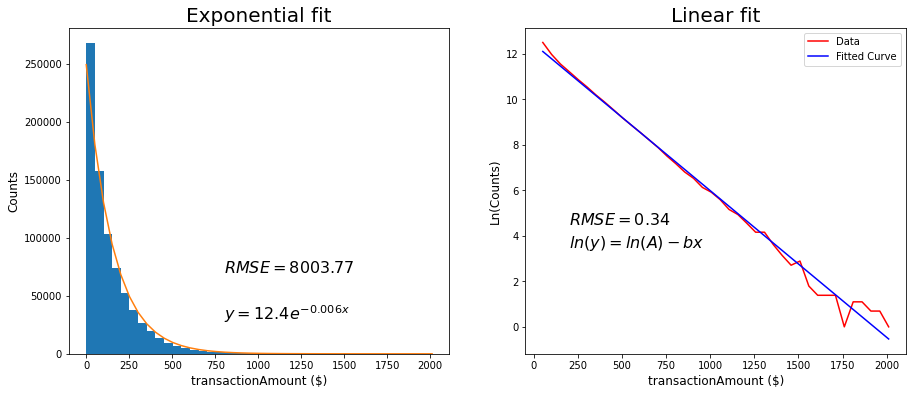

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error

# plot the transactionAmount data as a histogram
# return arrays of the counts for each bin and the bin boundries
fig, ax = plt.subplots(1,2, figsize=(15,6))
counts, bins, _= ax[0].hist(df['transactionAmount'], bins=40)

# fill in values of 0 counts with the previous non-zero value
from tqdm.notebook import trange
for i in trange(len(counts)):
  j = 1
  while counts[i] == 0.0:
    counts[i] = counts[i-j]
    j += 1

# dropping the first bin value to align the arrays
# take the log of counts to transfrom from exponential relation to linear
X = bins[1:]
y = np.log(counts)

# fit X and y to a line
params = np.polyfit(X,y,1)

# format the equation as a latex string for plotting
exp_eqn = '$y={:.1f}e^{:.3f}x$'.format(params[1],params[0])
for i in range(len(exp_eqn)):
  if exp_eqn[i] == '^':
    exp_eqn = exp_eqn[:i+1]+'{'+exp_eqn[i+1:]
    break
for i in range(len(exp_eqn)):
  if exp_eqn[i] == 'x':
    exp_eqn = exp_eqn[:i+1]+'}'+exp_eqn[i+1:]
    break

# calculate the root mean squared error of the counts and the exponential fitted results
rmse = np.sqrt(mean_squared_error(counts,np.exp(params[1])*np.exp(params[0]*bins[:-1])))
rmse = "$RMSE={:.2f}$".format(rmse)
# calculate the root mean squared error of the log(counts) and the linear fit
rmse_log = np.sqrt(mean_squared_error(y,params[0]*X+params[1]))
rmse_log = "$RMSE={:.2f}$".format(rmse_log)

# plot the results of the exponential and linear fit
ax[0].set_title("Exponential fit", fontsize=20)
ax[0].plot(bins,np.exp(params[1])*np.exp(params[0]*bins))
ax[0].set_ylabel("Counts",fontsize=12)
ax[0].set_xlabel("transactionAmount ($)",fontsize=12)
ax[0].annotate(exp_eqn, xy=(800,30000), xytext=(800,30000),fontsize=(16))
ax[0].annotate(rmse, xy=(800,70000), xytext=(800,70000),fontsize=(16))
ax[1].plot(X,y, 'r-', label="Data")
ax[1].plot(X,params[0]*X+params[1], 'b-', label="Fitted Curve")
ax[1].set_title("Linear fit", fontsize=20)
ax[1].annotate(r'$ln(y)=ln(A)-bx$', xy=(200,3.5), xytext=(200,3.5),fontsize=(16))
ax[1].annotate(rmse_log, xy=(200,4.5), xytext=(200,4.5),fontsize=(16))
ax[1].set_ylabel("Ln(Counts)",fontsize=12)
ax[1].set_xlabel("transactionAmount ($)",fontsize=12)
ax[1].legend()
plt.show()

## Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.
*   Can you programmatically identify reversed and multi-swipe transactions?
*   What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
*   Did you find anything interesting about either kind of transaction?

First, I found reveresed transactions by grouping the data by accountNumber and ordering the results by date. Then, I checked if there are any transaction amounts for the same value. 

In [6]:
# reindex the dataset to easily loop through each accounts tranactions
grouped = df.set_index(['accountNumber','index'])

# Loop through each accounts transations and look for repeated values in 
# transactionAmount. Store the indices of the repeated values in repeats
# with the format [accountNumber,[index,...,index],...]. This will only record
# the repeated values
repeats = []
from tqdm.notebook import tqdm
for account in tqdm(grouped.index.get_level_values(0).drop_duplicates()):
  if grouped['transactionAmount'].loc[account].duplicated(keep='first').sum():
    repeats.append([account,(grouped['transactionAmount'].loc[account].index[grouped['transactionAmount'].loc[account].duplicated(keep='first') == True]).tolist()])

# repeats is a list of lists where each list contains the account number
# transaction index for that account that were repeated transactions.


In [8]:
# loop through the repeats list and count the number of repeated values. 
# Print the percentage of transactions that were repeats
length = 0
from tqdm.notebook import trange
for i in trange(len(repeats)):
  length += len(repeats[i][1])
print("There were ",length," transactions where the accountNumber and ",
      "transactionNumber matched.")
print("That means that {:.2f} % of transactions were duplicates".format(100*length/len(df['transactionAmount'])))


There were  110600  transactions where the accountNumber and  transactionNumber matched.
That means that 14.06 % of transactions were duplicates


## Model

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.
*   Each of the transactions in the dataset has a field called `isFraud`. Please 
build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
*   Provide an estimate of performance using an appropriate sample, and show your work.
*   Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Create a list of all the columns to use for training the model
train_vars =['accountNumber','creditLimit','availableMoney',
             'transactionAmount','merchantName','acqCountry','merchantCountryCode',
             'posEntryMode','posConditionCode','merchantCategoryCode'
             ,'transactionType',
             'currentBalance','cardPresent','expirationDateKeyInMatch']

# convert datatype of discrete integers to categorical data for modeling
df['accountNumber'] = df['accountNumber'].astype('category').cat.codes
df['merchantName'] = df['merchantName'].astype('category').cat.codes
df['acqCountry'] = df['acqCountry'].astype('category').cat.codes
df['merchantCountryCode'] = df['merchantCountryCode'].astype('category').cat.codes
df['merchantCategoryCode'] = df['merchantCategoryCode'].astype('category').cat.codes
df['transactionType'] = df['transactionType'].astype('category').cat.codes

# convert datetime values to numeric values for modeling
epoch = datetime.utcfromtimestamp(0)
def time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0
#df['accountOpenDate'] = df['accountOpenDate'].apply(time_millis)
#df['accountOpenDate'] = df['transactionDateTime'].apply(time_millis)
#df['currentExpDate'] = df['currentExpDate'].apply(time_millis)
#df['accountOpenDate'] = df['accountOpenDate'].apply(time_millis)
#df['dateOfLastAddressChange'] = df['dateOfLastAddressChange'].apply(time_millis)

# resample data to increse the number of fraudulent transactions to be equal
# to non-fraudulent transactions. This is to remove the bias in decision tree
# classifiers
df_fraud = df[df['isFraud']==True]
df_notfraud = df[df['isFraud']==False]
df_fraud_upsampled = resample(df_fraud,replace=True,n_samples=len(df_notfraud))
df_upsampled = pd.concat([df_notfraud,df_fraud_upsampled])

# split the data to train and test sets for validation
X_train, X_test, y_train, y_test = train_test_split(df_upsampled[train_vars], 
                    df_upsampled['isFraud'], test_size=0.33, random_state=0)

In [14]:
# initalize a random forest classifier and fit it with the training set
model = RandomForestClassifier(n_estimators=200 ,max_depth=30, random_state=0, 
                               n_jobs=2,verbose=1)
model.fit(X_train,y_train)

# predit the outputs of the model from the test set
predict_fraud = model.predict(X_test)

print("The model's accuracy on the training set is {:.2f}".format(model.score(X_test,y_test)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  7.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   23.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   23.0s


The model's accuracy on the training set is 0.99


[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   23.4s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   22.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   23.1s finished


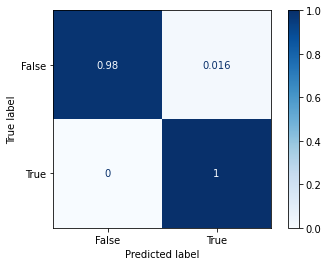

In [13]:
# plot a confustion matrix to show the accuracy of the model.
disp = plot_confusion_matrix(model, X_test, y_test,
  display_labels=['False','True'], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title('Confusion matrix for test set',fontsize=16)